In [1]:
import os
import sys
import numpy as np
import glob
import pandas as pd
import shutil
import gzip
import nibabel
import scipy.io
import h5py
import matplotlib.pyplot as plt
import seaborn as sns
from nilearn.connectome import vec_to_sym_matrix
import scipy.stats
import utils
import math

In [2]:
paths = glob.glob('Data_CCS/All_age_groups_ccs/Outputs_ccs_nfng_all/ICA_all_ccs/All_age_ccs__sub*_timecourses_ica_s1_.nii')
print('Number of files : ', len(paths))
paths = np.sort(paths)

Number of files :  383


In [3]:
reference_vec = np.array([i for i in range(1378)], dtype = 'int')
reference_mat = np.array(utils.vec2mat(reference_vec), dtype='int')
np.fill_diagonal(reference_mat, -1)
print(reference_mat)
vec_recons = utils.mat2vec(reference_mat)
print(np.array_equal(vec_recons, reference_vec))

[[  -1    0    1 ...   49   50   51]
 [   0   -1   52 ...  100  101  102]
 [   1   52   -1 ...  150  151  152]
 ...
 [  49  100  150 ...   -1 1375 1376]
 [  50  101  151 ... 1375   -1 1377]
 [  51  102  152 ... 1376 1377   -1]]
True


In [4]:
# Testing the mat2vec function 
# path = './Data_CCS/All_age_groups_ccs/Outputs_ccs_nfng_all/DFNC_all_ccs/'
# tt = scipy.io.loadmat(path + 'Stats_L1_ws20_city/All_age_ccs__dfnc_two_sample_ttest_results.mat')
# print('Two sample ttest using GIFT mat file keys : ', tt.keys())

# p_state1_gift = np.array(tt['p_u'][0][0][0], dtype = 'float64')
# p_mat = utils.vec2mat(p_state1_gift)
# p_vec = mat2vec(p_mat)
# print(np.array_equal(p_vec, p_state1_gift))

In [5]:
def get_corr_matrix(df):
    with np.errstate(invalid="ignore"):
        corr = np.nan_to_num(np.corrcoef(df.T))
        return corr

In [6]:
all_corr = []
for path in paths : 
    x = nibabel.load(path).get_fdata()
    x = np.array(x, dtype = 'float32')
    corr = get_corr_matrix(x)
    corr = utils.mat2vec(corr)
    all_corr.append(corr)
    
all_corr = np.array(all_corr, dtype = 'float32')
print('Shape of correlations vector : ', all_corr.shape)

Shape of correlations vector :  (383, 1378)


In [7]:
np.isnan(all_corr).all()

False

In [8]:
asd_idx = np.array(range(188), dtype = 'uint32')
td_idx = np.array(range(188,383), dtype = 'uint32')
groups = {'ASD' : asd_idx, 'TD' : td_idx}
print('Number of ASD subjects : ', len(asd_idx))
print('Number of TD subjects : ', len(td_idx))

Number of ASD subjects :  188
Number of TD subjects :  195


# Two sample ttest on SFC

In [9]:
t_sfc, p_sfc = [], []
for i in range(1378):
    group1 = all_corr[asd_idx, i]
    group2 = all_corr[td_idx, i]
    t, p = scipy.stats.ttest_ind(group1, group2)
    t_sfc.append(t)
    p_sfc.append(p)
    
t_sfc = np.array(t_sfc, dtype = 'float64')
p_sfc = np.array(p_sfc, dtype = 'float64')
print(t_sfc.shape)
print(p_sfc.shape)
print("Number of significant connectivities in SFC : ", (p_sfc < 0.05).sum())

(1378,)
(1378,)
Number of significant connectivities in SFC :  225


# Generating SFC P values files

In [10]:
nm_labels = pd.read_excel('./Phenotypes/NM_Template_Labels.xlsx', index_col = 'Indices')
nm_labels.head()

,ROI,Network
Indices,,
1,Caudate (1),SC
2,Subthalamus/hypothalamus (2),SC
3,Putamen (3),SC
4,Caudate (4),SC
5,Thalamus (5),SC


In [11]:
p_inds = np.argsort(p_sfc)
p_inds

array([1333, 1345, 1291, ...,  426, 1193,  503])

In [52]:
p_inds = np.argsort(p_sfc)
conn_indices, p_values, asd_means, td_means, asd_stds, td_stds, dominant_group =  [], [],  [], [], [], [], []
first_roi_indices, second_roi_indices, first_roi_names, second_roi_names = [], [], [], []
for idx in p_inds : 

    twod_indices = np.array(np.where(reference_mat == idx), dtype = 'uint32') + 1 
    first_idx = twod_indices[0,0]
    second_idx = twod_indices[0,1]
    first_roi = str(nm_labels.loc[first_idx]['ROI'])
    second_roi = str(nm_labels.loc[second_idx]['ROI'])
    p_val = p_sfc[idx]

    asd_mean = np.mean(all_corr[asd_idx, idx])
    td_mean = np.mean(all_corr[td_idx, idx])
    asd_std = np.std(all_corr[asd_idx, idx])
    td_std = np.std(all_corr[td_idx, idx])
    dominant = 'ASD' if asd_mean > td_mean else 'TD'

    first_roi_indices.append(first_idx)
    second_roi_indices.append(second_idx)
    first_roi_names.append(first_roi)
    second_roi_names.append(second_roi)

    conn_indices.append(idx)
    p_values.append(p_val)
    asd_means.append(asd_mean)
    td_means.append(td_mean)
    asd_stds.append(asd_std)
    td_stds.append(td_std)
    dominant_group.append(dominant)

    
df_p = pd.DataFrame({'Connectivity_Index' : conn_indices, 'First_ROI_Index' : first_roi_indices,
                        'First_ROI_Name' : first_roi_names, 'Second_ROI_Index' : second_roi_indices, 
                        'Second_ROI_Name' : second_roi_names, 'P_Values' : p_values, 
                        'ASD_Mean' : asd_means, 'TD_Mean' : td_means, 'ASD_STD' : asd_stds, 
                        'TD_STD' : td_stds, 'Dominant_Group' : dominant_group})

                        
df_p.to_csv('./Phenotypes/States/SFC_P_Values.csv')    
df_p.head()                    

,Connectivity_Index,First_ROI_Index,First_ROI_Name,Second_ROI_Index,Second_ROI_Name,P_Values,ASD_Mean,TD_Mean,ASD_STD,TD_STD,Dominant_Group
0,1333,44,Precuneus (44),45,"Anterior cingulate cortex ([ACC], 45)",3.255792e-08,0.157646,0.310976,0.278139,0.251917,TD
1,1345,45,"Anterior cingulate cortex ([ACC], 45)",49,"Posterior cingulate cortex ([PCC], 49)",9.175825e-08,0.357551,0.487728,0.241193,0.225179,TD
2,1291,40,"Inferior frontal gyrus ([IFG], 40)",45,"Anterior cingulate cortex ([ACC], 45)",8.377528e-06,0.056438,-0.070029,0.284548,0.261804,ASD
3,1263,38,"Left inferior parietal lobule ([L IPL], 38)",44,Precuneus (44),1.313626e-05,-0.208257,-0.308739,0.234794,0.209031,ASD
4,1260,38,"Left inferior parietal lobule ([L IPL], 38)",41,"Middle frontal gyrus ([MiFG], 41)",1.441668e-05,0.042527,-0.057341,0.224263,0.219316,ASD


# Generating SFC Analysis file

In [41]:
all_corr = all_corr[:,:,np.newaxis]
all_corr.shape

(383, 1378, 1)

In [43]:
df = pd.read_csv('./Phenotypes/Final_Subjects.csv', index_col='SUB_ID')
print('Shape of final dataset : ', df.shape)
df.head()

Shape of final dataset :  (383, 104)


,subject,SITE_ID,FILE_ID,DX_GROUP,DSM_IV_TR,AGE_AT_SCAN,SEX,HANDEDNESS_CATEGORY,HANDEDNESS_SCORES,FIQ,...,qc_anat_notes_rater_2,qc_func_rater_2,qc_func_notes_rater_2,qc_anat_rater_3,qc_anat_notes_rater_3,qc_func_rater_3,qc_func_notes_rater_3,SUB_IN_SMP,TR,Timeframes
SUB_ID,,,,,,,,,,,,,,,,,,,,,
50182,50182,SDSU,SDSU_0050182,1,2,16.61,0,R,NaN,115.0,...,NaN,OK,NaN,OK,NaN,OK,NaN,1,2000.0,176.0
50183,50183,SDSU,SDSU_0050183,1,1,14.14,0,R,NaN,139.0,...,NaN,OK,NaN,OK,NaN,OK,NaN,1,2000.0,176.0
50184,50184,SDSU,SDSU_0050184,1,2,17.15,0,R,NaN,141.0,...,NaN,OK,NaN,OK,NaN,OK,NaN,0,2000.0,176.0
50186,50186,SDSU,SDSU_0050186,1,2,12.13,0,R,NaN,112.0,...,NaN,OK,NaN,OK,NaN,OK,NaN,1,2000.0,176.0
50187,50187,SDSU,SDSU_0050187,1,2,16.48,0,R,NaN,113.0,...,NaN,OK,NaN,OK,NaN,OK,NaN,1,2000.0,176.0


In [42]:
input_paths = np.loadtxt('./Data_CCS/All_age_groups_ccs/Mask_ccs_all/All_ccs__input_files.txt', dtype = 'str')
print('Total number of input files : ', len(input_paths))
input_paths = np.array(input_paths, dtype = 'str')
input_paths[ : 5]

Total number of input files :  383


array(['/scratch/Krishna/Data_CCS/All_age_groups_ccs/Inputs_ccs_nfng_all/ASD_ASP_NYU_0050969_func_preproc.nii',
       '/scratch/Krishna/Data_CCS/All_age_groups_ccs/Inputs_ccs_nfng_all/ASD_ASP_NYU_0050970_func_preproc.nii',
       '/scratch/Krishna/Data_CCS/All_age_groups_ccs/Inputs_ccs_nfng_all/ASD_ASP_NYU_0050972_func_preproc.nii',
       '/scratch/Krishna/Data_CCS/All_age_groups_ccs/Inputs_ccs_nfng_all/ASD_ASP_NYU_0050973_func_preproc.nii',
       '/scratch/Krishna/Data_CCS/All_age_groups_ccs/Inputs_ccs_nfng_all/ASD_ASP_NYU_0050974_func_preproc.nii'],
      dtype='<U103')

In [44]:
all_states_ados_total = utils.get_ados_dict(all_corr, df, input_paths, groups,  n_states = 1, feature='ADOS_TOTAL')
all_states_ados_comm = utils.get_ados_dict(all_corr, df, input_paths, groups,  n_states = 1, feature='ADOS_COMM')
all_states_ados_social = utils.get_ados_dict(all_corr, df, input_paths, groups,  n_states = 1, feature='ADOS_SOCIAL')
all_states_ados_stereo = utils.get_ados_dict(all_corr, df, input_paths, groups,  n_states = 1, feature='ADOS_STEREO_BEHAV')

State :  1
Group: ASD and DFNC shape : (129, 1378)
ADOS minimum: 4.0, ADOS maximum: 22.0
------------------------------------------------
State :  1
Group: ASD and DFNC shape : (128, 1378)
ADOS minimum: 0.0, ADOS maximum: 8.0
------------------------------------------------
State :  1
Group: ASD and DFNC shape : (129, 1378)
ADOS minimum: 2.0, ADOS maximum: 14.0
------------------------------------------------
State :  1
Group: ASD and DFNC shape : (127, 1378)
ADOS minimum: 0.0, ADOS maximum: 7.0
------------------------------------------------


In [47]:
all_states_ados_total[0]

{'File_Index': array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  29,  33,  34,  35,  36,
         37,  38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,
         50,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,
         63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,
         76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,
         89,  90, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134,
        135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147,
        148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160,
        161, 162, 163, 164, 165, 170, 171, 172, 173, 174, 176, 177],
       dtype=int32),
 'File_Id': array([50969, 50970, 50972, 50973, 50974, 50976, 50977, 50978, 50979,
        51015, 51016, 51017, 51018, 51019, 50182, 50184, 50186, 50187,
        50189, 50190, 50212, 50607, 50642, 50646, 50647, 50649, 50653,
        50654, 

In [53]:
len(all_states_ados_total)

1

In [48]:
all_states_ados_total[0].keys()

dict_keys(['File_Index', 'File_Id', 'Correlation', 'ADOS_TOTAL'])

In [51]:
all_states_ados_total[0]['Correlation'].shape

(129, 1378)

In [46]:
(p_sfc < 0.05).sum()

225

In [57]:
state_ados_corr_total, pvalues_total, state_indices_total = utils.get_ados_corr(all_states_ados_total, p_sfc, state = 0, feature='ADOS_TOTAL')
print('-' * 8)
state_ados_corr_comm, pvalues_comm, state_indices_comm = utils.get_ados_corr(all_states_ados_comm, p_sfc, state = 0, feature='ADOS_COMM')
print('-' * 8)
state_ados_corr_social, pvalues_social, state_indices_social = utils.get_ados_corr(all_states_ados_social, p_sfc, state = 0, feature='ADOS_SOCIAL')
print('-' * 8)
state_ados_corr_stereo, pvalues_stereo, state_indices_stereo = utils.get_ados_corr(all_states_ados_stereo, p_sfc, state = 0, feature='ADOS_STEREO_BEHAV')
print('-' * 8)

conn_indices, corrs_total, corrs_social, corrs_comm, corrs_stereo = [], [], [], [], []
df = {}
n_significant = len(state_indices_total)

assert np.array_equal(state_indices_total, state_indices_comm), "Error !"
assert np.array_equal(state_indices_social, state_indices_stereo), "Error !"
    
assert np.array_equal(pvalues_total, pvalues_comm), "Error !"
assert np.array_equal(pvalues_social, pvalues_stereo), "Error !"

for index in  range(n_significant): 
    conn_index = state_indices_total[index]
    p = pvalues_total[index]
    total = state_ados_corr_total[index]
    comm = state_ados_corr_comm[index]
    social = state_ados_corr_social[index]
    stereo = state_ados_corr_stereo[index]


    conn_indices.append(conn_index)
    corrs_total.append(total)
    corrs_comm.append(comm)
    corrs_social.append(social)
    corrs_stereo.append(stereo)


df['Connectivity_Index'] = conn_indices

df['ADOS_TOTAL_Corr'] = np.array(corrs_total, dtype = 'float32')
df['ADOS_COMM_Corr'] = np.array(corrs_comm, dtype = 'float32')
df['ADOS_SOCIAL_Corr'] = np.array(corrs_social, dtype = 'float32')
df['ADOS_STEREO_Corr'] = np.array(corrs_stereo, dtype = 'float32')

df = pd.DataFrame(df, columns = ['Connectivity_Index', 'ADOS_TOTAL_Corr', 'ADOS_COMM_Corr', 'ADOS_SOCIAL_Corr', 'ADOS_STEREO_Corr'])
df.sort_values(by=['ADOS_TOTAL_Corr'], axis = 0, inplace = True)
print('Shape of  ADOS dataset : ', df.shape)

temp = pd.read_csv(f'./Phenotypes/States/SFC_P_Values.csv')
print('Shape of P_values dataset : ', temp.shape)

df_merge = df.merge(temp, how = 'left', on = 'Connectivity_Index')
print('Shape after merge : ', df_merge.shape)
df_merge.to_csv(f'./Phenotypes/States/SFC_Analysis.csv')
df_merge.head()

State correlations matrix :  (129, 1378)
State ados array shape :  (129,)
Number of connectivities turned to be significant :  225
ADOS correlation scores array shape :  (225,)
Max correlation value :  0.2325487
Max correlation p-value :  0.008048099
Min correlation value :  -0.24343944
Min correlation p-value :  0.002883767
--------
State correlations matrix :  (128, 1378)
State ados array shape :  (128,)
Number of connectivities turned to be significant :  225
ADOS correlation scores array shape :  (225,)
Max correlation value :  0.26020676
Max correlation p-value :  0.025913097
Min correlation value :  -0.25827268
Min correlation p-value :  0.00025885296
--------
State correlations matrix :  (129, 1378)
State ados array shape :  (129,)
Number of connectivities turned to be significant :  225
ADOS correlation scores array shape :  (225,)
Max correlation value :  0.22061282
Max correlation p-value :  0.014827712
Min correlation value :  -0.24160616
Min correlation p-value :  0.0028837

,Connectivity_Index,ADOS_TOTAL_Corr,ADOS_COMM_Corr,ADOS_SOCIAL_Corr,ADOS_STEREO_Corr,Unnamed: 0,First_ROI_Index,First_ROI_Name,Second_ROI_Index,Second_ROI_Name,P_Values,ASD_Mean,TD_Mean,ASD_STD,TD_STD,Dominant_Group
0,1067,-0.243439,-0.168844,-0.241606,0.027303,49,28,"Superior medial frontal gyrus ([SMFG], 28)",43,Precuneus (43),0.002884,-0.066555,0.010197,0.259670,0.239711,TD
1,3,-0.221914,-0.235344,-0.173132,0.027638,96,1,Caudate (1),5,Thalamus (5),0.010689,0.273873,0.361690,0.319255,0.347690,TD
2,1323,-0.217414,-0.188735,-0.193374,-0.176956,19,43,Precuneus (43),44,Precuneus (44),0.000306,0.307706,0.394103,0.229516,0.233188,TD
3,1017,-0.207691,-0.171606,-0.195410,-0.039656,104,26,"Inferior parietal lobule ([IPL], 26)",44,Precuneus (44),0.013086,0.097161,0.159585,0.265263,0.222273,TD
4,266,-0.190804,-0.196478,-0.154181,-0.010478,74,6,"Superior temporal gyrus ([STG], 6)",23,"Inferior occipital gyrus ([IOG], 23)",0.006541,-0.098355,-0.035369,0.224908,0.224638,TD


In [59]:
sfc = pd.read_csv(f'./Phenotypes/States/SFC_Analysis.csv')
sfc['First_ROI_Network'] = nm_labels.loc[sfc['First_ROI_Index']]['Network'].values
sfc['Second_ROI_Network'] = nm_labels.loc[sfc['Second_ROI_Index']]['Network'].values
sfc[['First_ROI_Network', 'First_ROI_Index', 'Second_ROI_Index', 'Second_ROI_Network']]

,First_ROI_Network,First_ROI_Index,Second_ROI_Index,Second_ROI_Network
0,CC,28,43,DM
1,SC,1,5,SC
2,DM,43,44,DM
3,CC,26,44,DM
4,AUD,6,23,VIS
...,...,...,...,...
220,VIS,17,51,CB
221,VIS,23,42,CC
222,AUD,6,39,CC
223,AUD,6,26,CC


In [60]:
print(f"Number of distinct connectivities less than 0.05: {(sfc['P_Values'] < 0.05).sum()}")
sfc['ROI-Pair'] = sfc['First_ROI_Network'] + '-' + sfc['Second_ROI_Network'] 
all_pairs = pd.DataFrame(sfc['ROI-Pair'].value_counts())
asd_pairs = pd.DataFrame(sfc[sfc['Dominant_Group'] == 'ASD']['ROI-Pair'].value_counts())
asd_pairs.rename(columns={'ROI-Pair' : 'ASD-Dominant'}, inplace = True)
td_pairs = pd.DataFrame(sfc[sfc['Dominant_Group'] == 'TD']['ROI-Pair'].value_counts())
td_pairs.rename(columns={'ROI-Pair' : 'TD-Dominant'}, inplace = True)
combined_df = pd.concat([all_pairs, asd_pairs, td_pairs], axis=1)
combined_df

Number of distinct connectivities less than 0.05: 225


,ROI-Pair,ASD-Dominant,TD-Dominant
CC-DM,42,24.0,18.0
CC-CC,35,19.0,16.0
VIS-CC,16,7.0,9.0
VIS-DM,14,9.0,5.0
SM-DM,13,12.0,1.0
SC-CC,13,2.0,11.0
DM-DM,12,NaN,12.0
SM-CC,10,4.0,6.0
VIS-VIS,8,5.0,3.0
CC-CB,7,NaN,7.0


In [61]:
combined_df.sum()

ROI-Pair        225.0
ASD-Dominant    111.0
TD-Dominant     114.0
dtype: float64

In [62]:
all_corr.shape

(383, 1378, 1)

# Generating SFC centroids

In [19]:
asd_mean = np.mean(all_corr[asd_idx], axis = 0)
td_mean = np.mean(all_corr[td_idx], axis = 0)
print('ASD mean shape: ', asd_mean.shape)
print('TD mean shape: ', td_mean.shape)
asd_mean_matrix = utils.vec2mat(asd_mean)
td_mean_matrix = utils.vec2mat(td_mean)
print('ASD mean matrix shape: ', asd_mean_matrix.shape)
print('TD mean matrix shape: ', td_mean_matrix.shape)

ASD mean shape:  (1378,)
TD mean shape:  (1378,)
ASD mean matrix shape:  (53, 53)
TD mean matrix shape:  (53, 53)


In [24]:
asd_df = pd.DataFrame(asd_mean_matrix, columns = range(1,54), index = range(1,54))
asd_df.to_csv('./Phenotypes/Centroids/ASD_SFC.csv')
asd_df.head()

,1,2,3,4,5,6,7,8,9,10,...,44,45,46,47,48,49,50,51,52,53
1,1.000000,0.155435,0.181685,0.454941,0.273873,-0.007678,0.076137,-0.006972,-0.094944,-0.108181,...,-0.070054,0.202210,-0.078959,0.126348,-0.162705,-0.050566,0.019278,-0.003422,0.031235,0.027397
2,0.155435,1.000000,0.330481,0.303187,0.121979,0.020853,0.137518,0.106856,0.006094,-0.213030,...,-0.014860,-0.028225,-0.073138,-0.017545,-0.153477,-0.150140,0.033391,-0.130786,0.138785,-0.004252
3,0.181685,0.330481,1.000000,0.469252,0.300398,0.165922,0.297560,0.164239,0.029894,-0.166543,...,-0.052599,0.028802,0.013409,-0.041714,-0.151991,-0.110222,0.035067,-0.164563,0.044206,-0.060588
4,0.454941,0.303187,0.469252,1.000000,0.241614,0.114167,0.224396,0.030702,-0.024916,-0.104794,...,-0.105605,0.183142,-0.037446,0.139898,-0.132933,-0.101747,0.053862,-0.127427,0.011556,-0.020877
5,0.273873,0.121979,0.300398,0.241614,1.000000,0.053391,0.043206,0.076785,0.070352,0.006521,...,0.036461,-0.014023,0.111926,-0.045769,-0.013745,-0.025780,0.109842,-0.039951,-0.019770,0.001939


In [25]:
td_df = pd.DataFrame(td_mean_matrix, columns = range(1,54), index = range(1,54))
td_df.to_csv('./Phenotypes/Centroids/TD_SFC.csv')
td_df.head()

,1,2,3,4,5,6,7,8,9,10,...,44,45,46,47,48,49,50,51,52,53
1,1.000000,0.150172,0.171915,0.479036,0.361690,-0.078545,0.038712,-0.029086,-0.119338,-0.132978,...,-0.008639,0.169659,-0.022768,0.146421,-0.171059,-0.018694,0.038702,0.100079,0.042450,0.073176
2,0.150172,1.000000,0.318764,0.318004,0.174762,0.007583,0.127542,0.094411,-0.031161,-0.201560,...,-0.032567,-0.016576,-0.078136,-0.035802,-0.178206,-0.122788,0.050997,-0.093482,0.176413,0.010997
3,0.171915,0.318764,1.000000,0.479279,0.251228,0.143103,0.271361,0.145652,-0.023425,-0.204947,...,-0.103471,-0.002576,-0.026816,-0.073393,-0.166295,-0.112704,0.042725,-0.156860,0.064993,-0.044605
4,0.479036,0.318004,0.479279,1.000000,0.264597,0.090047,0.199150,0.028419,-0.058861,-0.172412,...,-0.109569,0.176454,-0.033074,0.157275,-0.149473,-0.068021,0.056422,-0.062613,0.016287,-0.000464
5,0.361690,0.174762,0.251228,0.264597,1.000000,-0.028611,0.032413,-0.005057,0.018367,-0.060275,...,0.032817,0.010225,0.095918,-0.009966,-0.042427,-0.037124,0.113673,0.024721,0.020721,0.024837


In [28]:
np.array_equal(asd_mean_matrix, td_mean_matrix)

False

In [27]:
td_df.equals(asd_df)

False

# Genreate Connectograms

In [2]:
nm_labels = pd.read_excel('./Phenotypes/NM_Template_Labels.xlsx', index_col = 'Indices')
nm_labels.head()

,ROI,Network
Indices,,
1,Caudate (1),SC
2,Subthalamus/hypothalamus (2),SC
3,Putamen (3),SC
4,Caudate (4),SC
5,Thalamus (5),SC


Number of distinct connectivities less than 0.05: 225
Number of significant connection within and between CC, DM networks :  89
Number of non zero values in the above matrix : 178
Shape of centroid of CC-DM networks only (24, 24)
Number of non zero values in the Centroid CC-DM matrix : 178


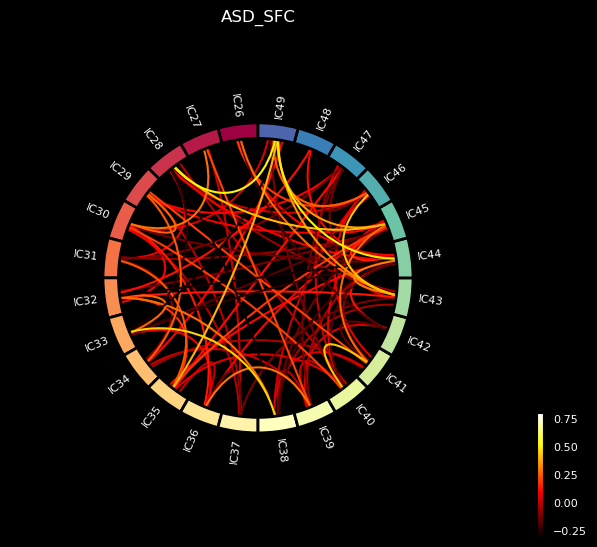

Number of distinct connectivities less than 0.05: 225
Number of significant connection within and between CC, DM networks :  89
Number of non zero values in the above matrix : 178
Shape of centroid of CC-DM networks only (24, 24)
Number of non zero values in the Centroid CC-DM matrix : 178


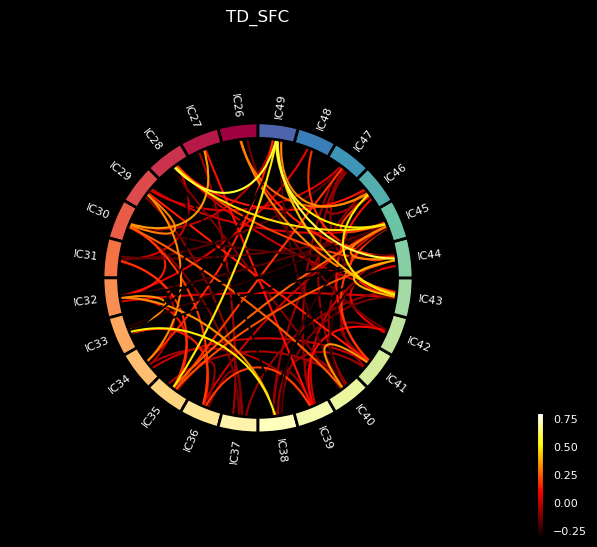

In [3]:
for group in ['ASD', 'TD']:

    sfc = pd.read_csv(f'./Phenotypes/States/SFC_Analysis.csv')
    sfc['First_ROI_Network'] = nm_labels.loc[sfc['First_ROI_Index']]['Network'].values
    sfc['Second_ROI_Network'] = nm_labels.loc[sfc['Second_ROI_Index']]['Network'].values
    print(f"Number of distinct connectivities less than 0.05: {(sfc['P_Values'] < 0.05).sum()}")
    sfc['ROI-Pair'] = sfc['First_ROI_Network'] + '-' + sfc['Second_ROI_Network'] 
    centroid = pd.read_csv(f'./Phenotypes/Centroids/{group}_SFC.csv', index_col='Unnamed: 0')
    utils.plot_CC_DM_connections(sfc, centroid, title = f'{group}_SFC', format = 'svg')


Number of distinct connectivities less than 0.05: 225
Number of significant connection within and between CC, DM networks :  89
Number of non zero values in the above matrix : 178
Shape of centroid of CC-DM networks only (24, 24)
Number of non zero values in the Centroid CC-DM matrix : 178


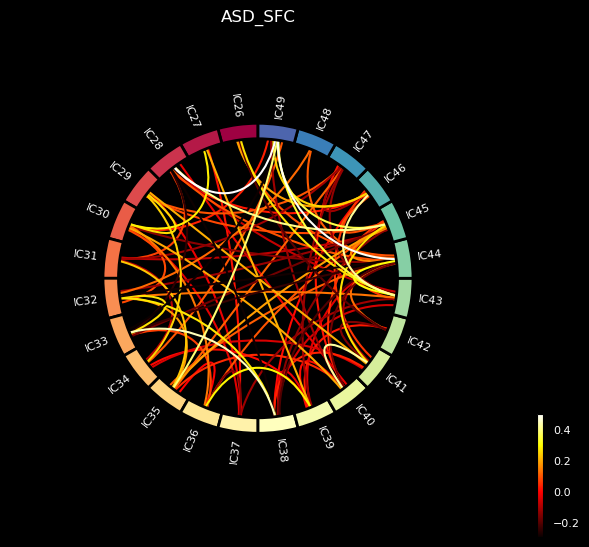

Number of distinct connectivities less than 0.05: 225
Number of significant connection within and between CC, DM networks :  89
Number of non zero values in the above matrix : 178
Shape of centroid of CC-DM networks only (24, 24)
Number of non zero values in the Centroid CC-DM matrix : 178


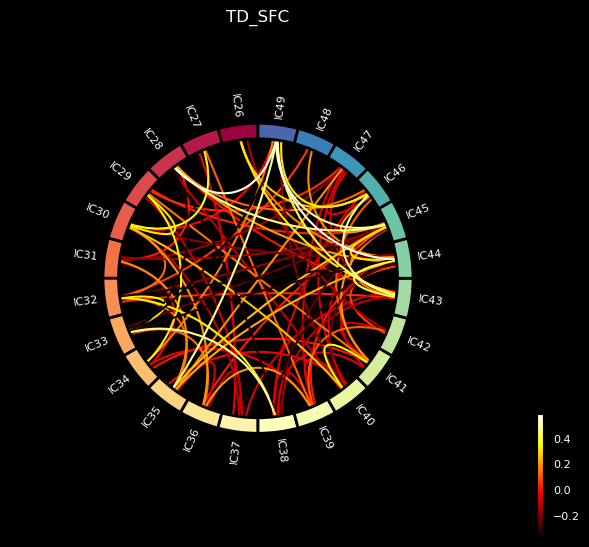

In [10]:
for group in ['ASD', 'TD']:

    sfc = pd.read_csv(f'./Phenotypes/States/SFC_Analysis.csv')
    sfc['First_ROI_Network'] = nm_labels.loc[sfc['First_ROI_Index']]['Network'].values
    sfc['Second_ROI_Network'] = nm_labels.loc[sfc['Second_ROI_Index']]['Network'].values
    print(f"Number of distinct connectivities less than 0.05: {(sfc['P_Values'] < 0.05).sum()}")
    sfc['ROI-Pair'] = sfc['First_ROI_Network'] + '-' + sfc['Second_ROI_Network'] 
    centroid = pd.read_csv(f'./Phenotypes/Centroids/{group}_SFC.csv', index_col='Unnamed: 0')
    utils.plot_CC_DM_connections(sfc, centroid, title = f'{group}_SFC', format = 'png')


Number of distinct connectivities less than 0.05: 225
Number of significant connection within and between CC, DM networks :  89
Number of non zero values in the above matrix : 178
Shape of centroid of CC-DM networks only (24, 24)
Number of non zero values in the Centroid CC-DM matrix : 178


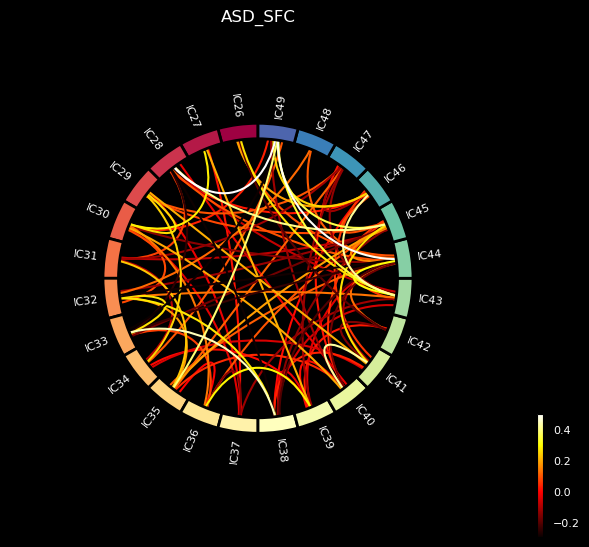

Number of distinct connectivities less than 0.05: 225
Number of significant connection within and between CC, DM networks :  89
Number of non zero values in the above matrix : 178
Shape of centroid of CC-DM networks only (24, 24)
Number of non zero values in the Centroid CC-DM matrix : 178


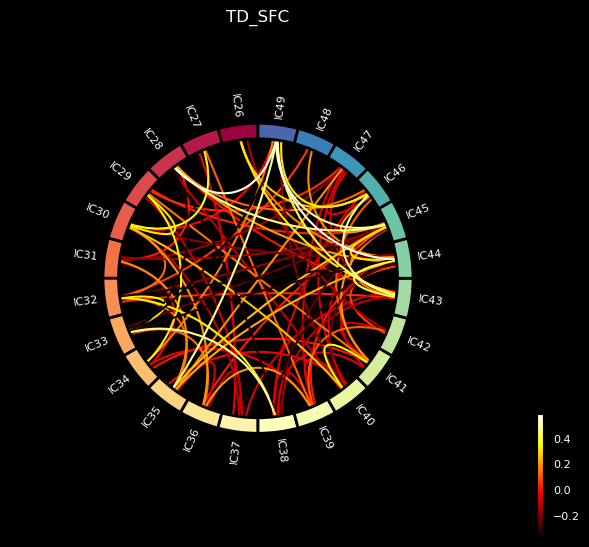

In [13]:
for group in ['ASD', 'TD']:

    sfc = pd.read_csv(f'./Phenotypes/States/SFC_Analysis.csv')
    sfc['First_ROI_Network'] = nm_labels.loc[sfc['First_ROI_Index']]['Network'].values
    sfc['Second_ROI_Network'] = nm_labels.loc[sfc['Second_ROI_Index']]['Network'].values
    print(f"Number of distinct connectivities less than 0.05: {(sfc['P_Values'] < 0.05).sum()}")
    sfc['ROI-Pair'] = sfc['First_ROI_Network'] + '-' + sfc['Second_ROI_Network'] 
    centroid = pd.read_csv(f'./Phenotypes/Centroids/{group}_SFC.csv', index_col='Unnamed: 0')
    utils.plot_CC_DM_connections(sfc, centroid, title = f'{group}_SFC', format = 'svg')


In [12]:
sfc = pd.read_csv(f'./Phenotypes/States/SFC_Analysis.csv')
sfc['First_ROI_Network'] = nm_labels.loc[sfc['First_ROI_Index']]['Network'].values
sfc['Second_ROI_Network'] = nm_labels.loc[sfc['Second_ROI_Index']]['Network'].values
print(f"Number of distinct connectivities less than 0.05: {(sfc['P_Values'] < 0.05).sum()}")
sfc['Networks'] = sfc['First_ROI_Network'] + '-' + sfc['Second_ROI_Network'] 
sfc.to_csv('./Phenotypes/States/SFC_Analysis.csv')

Number of distinct connectivities less than 0.05: 225


Number of distinct connectivities less than 0.05: 225
Number of significant connection within and between CC, DM networks :  43
Number of non zero values in the above matrix : 86
Shape of centroid of CC-DM networks only (24, 24)
Number of non zero values in the Centroid CC-DM matrix : 86


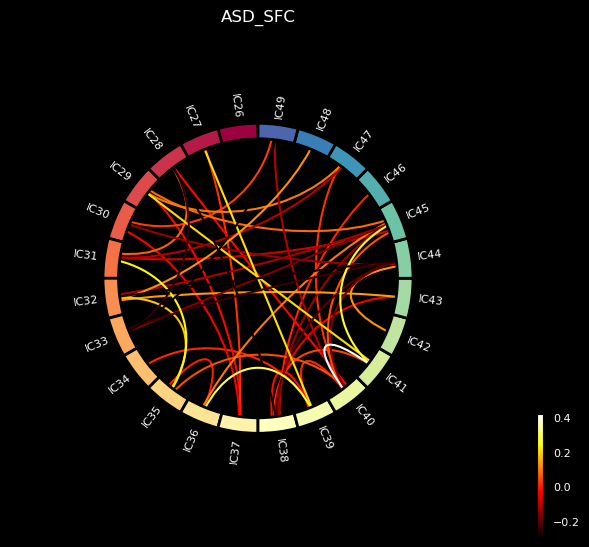

Number of distinct connectivities less than 0.05: 225
Number of significant connection within and between CC, DM networks :  46
Number of non zero values in the above matrix : 92
Shape of centroid of CC-DM networks only (24, 24)
Number of non zero values in the Centroid CC-DM matrix : 92


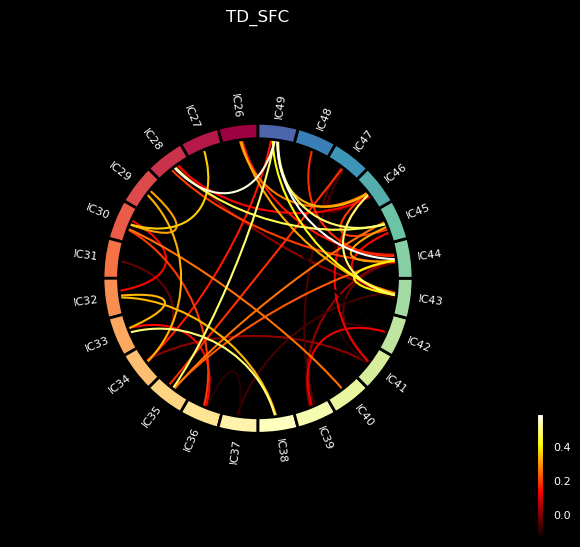

In [4]:
def plot_CC_DM_connections(state, centroid, title, group = None, format = 'png'):
    label_inds = np.array(range(1,54))
    centroid.index = label_inds
    centroid.columns = label_inds
    networks = ['CC-CC', 'CC-DM', 'DM-DM']
    if(group == None):
        state = state[state['Networks'].isin(networks)]
    else : 
        state = state[(state['Networks'].isin(networks)) & (state['Dominant_Group'] == group)]
    n = len(state)
    print('Number of significant connection within and between CC, DM networks : ', n)
    centroid_mat = np.zeros((53,53))
    for i in range(n):
        idx1 = state.iloc[i]['First_ROI_Index'].item()
        idx2 = state.iloc[i]['Second_ROI_Index'].item()
        assert idx1>=26 and idx1<=49, "Error!"
        assert idx2>=26 and idx2<=49, "Error!"
        centroid_mat[idx1-1, idx2-1] = centroid.loc[idx1][idx2].item()
        centroid_mat[idx2-1, idx1-1] = centroid.loc[idx2][idx1].item()

    print('Number of non zero values in the above matrix :', (centroid_mat!=0).sum())
    centroid_mat_cc_dm = centroid_mat[25:49, 25:49]
    print('Shape of centroid of CC-DM networks only', centroid_mat_cc_dm.shape)
    print('Number of non zero values in the Centroid CC-DM matrix :', (centroid_mat_cc_dm!=0).sum())
    nodes = ['IC' + str(node) for node in range(26,50)]
    utils.plot_connectogram(centroid_mat_cc_dm, nodes, n, title, format = format)
    return

for group in ['ASD', 'TD']:
    sfc = pd.read_csv(f'./Phenotypes/States/SFC_Analysis.csv')
    print(f"Number of distinct connectivities less than 0.05: {(sfc['P_Values'] < 0.05).sum()}")
    centroid = pd.read_csv(f'./Phenotypes/Centroids/{group}_SFC.csv', index_col='Unnamed: 0')
    plot_CC_DM_connections(sfc, centroid, title = f'{group}_SFC', group = group, format = 'svg')

# SFC at region level

In [21]:
sfc = pd.read_csv(f'./Phenotypes/States/SFC_Analysis.csv')
sfc['First_ROI_Network'] = nm_labels.loc[sfc['First_ROI_Index']]['Network'].values
sfc['Second_ROI_Network'] = nm_labels.loc[sfc['Second_ROI_Index']]['Network'].values
print(f"Number of distinct connectivities less than 0.05: {(sfc['P_Values'] < 0.05).sum()}")
sfc['ROI-Pair'] = sfc['First_ROI_Network'] + '-' + sfc['Second_ROI_Network'] 
sfc.head()

Number of distinct connectivities less than 0.05: 225


,Unnamed: 0,Connectivity_Index,ADOS_TOTAL_Corr,ADOS_COMM_Corr,ADOS_SOCIAL_Corr,ADOS_STEREO_Corr,Unnamed: 0.1,First_ROI_Index,First_ROI_Name,Second_ROI_Index,Second_ROI_Name,P_Values,ASD_Mean,TD_Mean,ASD_STD,TD_STD,Dominant_Group,First_ROI_Network,Second_ROI_Network,ROI-Pair
0,0,1067,-0.243439,-0.168844,-0.241606,0.027303,49,28,"Superior medial frontal gyrus ([SMFG], 28)",43,Precuneus (43),0.002884,-0.066555,0.010197,0.259670,0.239711,TD,CC,DM,CC-DM
1,1,3,-0.221914,-0.235344,-0.173132,0.027638,96,1,Caudate (1),5,Thalamus (5),0.010689,0.273873,0.361690,0.319255,0.347690,TD,SC,SC,SC-SC
2,2,1323,-0.217414,-0.188735,-0.193374,-0.176956,19,43,Precuneus (43),44,Precuneus (44),0.000306,0.307706,0.394103,0.229516,0.233188,TD,DM,DM,DM-DM
3,3,1017,-0.207691,-0.171606,-0.195410,-0.039656,104,26,"Inferior parietal lobule ([IPL], 26)",44,Precuneus (44),0.013086,0.097161,0.159585,0.265263,0.222273,TD,CC,DM,CC-DM
4,4,266,-0.190804,-0.196478,-0.154181,-0.010478,74,6,"Superior temporal gyrus ([STG], 6)",23,"Inferior occipital gyrus ([IOG], 23)",0.006541,-0.098355,-0.035369,0.224908,0.224638,TD,AUD,VIS,AUD-VIS


In [22]:
sfc[sfc['ROI-Pair'] == 'CC-CC'][['First_ROI_Name', 'Second_ROI_Name', 'Dominant_Group']].sort_values(by = 'Dominant_Group')

,First_ROI_Name,Second_ROI_Name,Dominant_Group
139,"Inferior frontal gyrus ([IFG], 40)","Middle frontal gyrus ([MiFG], 41)",ASD
198,"Left inferior parietal lobule ([L IPL], 38)","Middle frontal gyrus ([MiFG], 41)",ASD
193,"Superior medial frontal gyrus ([SMFG], 28)","Left inferior parietal lobue ([R IPL], 33)",ASD
181,"Middle cingulate cortex ([MCC], 39)","Inferior frontal gyrus ([IFG], 40)",ASD
151,"Left inferior parietal lobule ([L IPL], 38)","Middle cingulate cortex ([MCC], 39)",ASD
149,Insula (27),"Middle cingulate cortex ([MCC], 39)",ASD
148,"Superior frontal gyrus ([SFG], 35)","Inferior frontal gyrus ([IFG], 40)",ASD
147,"Superior medial frontal gyrus ([SMFG], 28)","Left inferior parietal lobule ([L IPL], 38)",ASD
142,"Inferior frontal gyrus ([IFG], 29)","Hippocampus ([HiPP], 37)",ASD
137,"Superior medial frontal gyrus ([SMFG], 28)","Middle frontal gyrus ([MiFG], 31)",ASD


In [23]:
sfc[(sfc['ROI-Pair'] == 'CC-CC') & (sfc['Dominant_Group'] == 'ASD')][['First_ROI_Index']].value_counts()

First_ROI_Index
28                 4
27                 2
29                 2
35                 2
38                 2
30                 1
31                 1
32                 1
34                 1
36                 1
39                 1
40                 1
dtype: int64

In [24]:
sfc[(sfc['ROI-Pair'] == 'CC-CC') & (sfc['Dominant_Group'] == 'ASD')][['Second_ROI_Index']].value_counts()

Second_ROI_Index
39                  4
37                  3
40                  3
41                  3
35                  2
31                  1
33                  1
36                  1
38                  1
dtype: int64

In [25]:
sfc[sfc['ROI-Pair'] == 'CC-DM'][['First_ROI_Name', 'Second_ROI_Name', 'Dominant_Group']].sort_values(by = 'Dominant_Group')

,First_ROI_Name,Second_ROI_Name,Dominant_Group
102,"Left inferior parietal lobue ([R IPL], 33)",Precuneus (44),ASD
105,"Inferior frontal gyrus ([IFG], 29)","Anterior cingulate cortex ([ACC], 47)",ASD
132,"Right inferior frontal gyrus ([R IFG], 30)","Posterior cingulate cortex ([PCC], 49)",ASD
135,"Middle frontal gyrus ([MiFG], 31)","Anterior cingulate cortex ([ACC], 47)",ASD
138,"Left inferior parietal lobue ([R IPL], 33)","Posterior cingulate cortex ([PCC], 49)",ASD
144,"Right inferior frontal gyrus ([R IFG], 30)",Precuneus (44),ASD
145,"Hippocampus ([HiPP], 42)",Precuneus (44),ASD
216,"Left inferior parietal lobule ([L IPL], 38)",Precuneus (43),ASD
153,"Inferior frontal gyrus ([IFG], 40)","Anterior cingulate cortex ([ACC], 45)",ASD
162,"Left inferior parietal lobule ([L IPL], 38)","Posterior cingulate cortex ([PCC], 46)",ASD


In [26]:
sfc[(sfc['ROI-Pair'] == 'CC-DM') & (sfc['Dominant_Group'] == 'ASD')][['First_ROI_Index']].value_counts()

First_ROI_Index
32                 4
38                 4
40                 4
33                 3
29                 2
30                 2
31                 2
36                 1
41                 1
42                 1
dtype: int64

In [27]:
sfc[(sfc['ROI-Pair'] == 'CC-DM') & (sfc['Dominant_Group'] == 'ASD')][['Second_ROI_Index']].value_counts()

Second_ROI_Index
45                  8
44                  6
47                  3
49                  3
43                  2
46                  1
48                  1
dtype: int64

In [28]:
sfc[sfc['ROI-Pair'] == 'DM-DM'][['First_ROI_Name', 'Second_ROI_Name', 'Dominant_Group']].sort_values(by = 'Dominant_Group')

,First_ROI_Name,Second_ROI_Name,Dominant_Group
2,Precuneus (43),Precuneus (44),TD
5,Precuneus (43),"Posterior cingulate cortex ([PCC], 49)",TD
7,"Anterior cingulate cortex ([ACC], 45)","Posterior cingulate cortex ([PCC], 46)",TD
8,Precuneus (43),"Anterior cingulate cortex ([ACC], 45)",TD
19,"Anterior cingulate cortex ([ACC], 45)","Posterior cingulate cortex ([PCC], 49)",TD
29,Precuneus (43),"Anterior cingulate cortex ([ACC], 47)",TD
30,Precuneus (43),"Posterior cingulate cortex ([PCC], 46)",TD
51,Precuneus (44),"Anterior cingulate cortex ([ACC], 45)",TD
54,"Posterior cingulate cortex ([PCC], 46)","Anterior cingulate cortex ([ACC], 47)",TD
60,Precuneus (44),Precuneus (48),TD


In [29]:
sfc[(sfc['ROI-Pair'] == 'DM-DM') & (sfc['Dominant_Group'] == 'TD')][['First_ROI_Index']].value_counts()

First_ROI_Index
43                 5
44                 3
45                 2
46                 2
dtype: int64

In [30]:
sfc[(sfc['ROI-Pair'] == 'DM-DM') & (sfc['Dominant_Group'] == 'TD')][['Second_ROI_Index']].value_counts()

Second_ROI_Index
49                  4
45                  2
46                  2
47                  2
44                  1
48                  1
dtype: int64

# Checking 

In [16]:
temp = pd.read_csv(f'./Phenotypes/States/State1_P_Values.csv')
print('Shape of P_values dataset : ', temp.shape)
indices = temp['Connectivity_Index'].values

Shape of P_values dataset :  (1378, 12)


In [33]:
path = './Data_CCS/All_age_groups_ccs/Outputs_ccs_nfng_all/DFNC_all_ccs/'
tt = scipy.io.loadmat(path + 'Stats_L1_ws20_city/All_age_ccs__dfnc_two_sample_ttest_results.mat')
print('Two sample ttest using GIFT mat file keys : ', tt.keys())

p_state1_gift = np.array(tt['p_u'][0][0][0], dtype = 'float64')
p_state1_gift = np.array(p_state1_gift, dtype = 'float64')
p_state1_gift = np.round(p_state1_gift, 4)

Two sample ttest using GIFT mat file keys :  dict_keys(['__header__', '__version__', '__globals__', 'groupNames', 'groupVals', 't_u', 'p_u', 'stats_u', 'N', 'mean_u', 'subject_indices'])


In [39]:
arr = np.zeros((1378))
for idx in indices:
    arr[idx] = temp.loc[temp['Connectivity_Index'] == idx]['P_Values'].item()
arr = np.round(arr, 4)
print(np.array_equal(arr, p_state1_gift))

True
